# Model Training

Prepare dataframe 

In [1]:
from random import shuffle

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from gensim.models import Word2Vec
from sklearn.svm import LinearSVC
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from utils.text_preprocess import LemmaTokenizer
import nltk
import numpy as np
from nltk.tokenize import sent_tokenize
from sklearn.experimental import enable_halving_search_cv

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
        
df = pd.read_csv('../data/amazon_reviews.txt', sep='\t')
df['VERIFIED_PURCHASE'] = df['VERIFIED_PURCHASE'].map({'Y': 1, 'N': 0})

word2vec_model_file = '../models/word2vec_100_v2.model'
model = Word2Vec.load(word2vec_model_file)

def average_word_embeddings(sentence, model):
    words = LemmaTokenizer()(sentence)
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    
    return np.mean(word_vectors, axis=0)

# Define a function to process each review
def process_review(review_text, model):
    sentences = sent_tokenize(review_text)
    sentence_embeddings = [average_word_embeddings(sentence, model) for sentence in sentences]
    return sentence_embeddings

df['Sentence_Embeddings'] = df['REVIEW_TEXT'].apply(lambda x: process_review(x, model))


[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt_tab: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
E:\PycharmProjects\amazon_fake_reviews_detection\utils\text_preprocess.py:28: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


Create pipelines

In [2]:
from utils.transformers import *
    
classifiers = [
    CalibratedClassifierCV(LinearSVC(random_state=42, dual="auto")),
    RandomForestClassifier(random_state=42, n_jobs=-1),
]
vectorizers = [
    TfidfVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None),
    CountVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None),
]

pipes = []
pipes_names = []
for clf in classifiers:
    for vectorizer in vectorizers:
        for useEmbeddings in [True]:
            for useVP in [True, False]:
                transformers = [
                    ('vectorizer', vectorizer, 'REVIEW_TEXT')
                ]
                if useEmbeddings:
                    transformers.append(('embeddings', SentenceEmbeddingTransformer(), 'Sentence_Embeddings'))
                if useVP:
                    transformers.append(('vp', OneHotEncoder(), ['VERIFIED_PURCHASE']))
                
                # No need for DenseTransformer for other classifiers
                pipes.append(Pipeline([
                    ('preprocessor', ColumnTransformer(transformers, n_jobs=-1)),
                    ('clf', clf)
                ]))
                    
                pipes_names.append(f'{clf.__class__.__name__}_'
                                   f'{vectorizer.__class__.__name__}'
                                   f'{"_WE" if useEmbeddings else ""}'
                                   f'{"_VP" if useVP else ""}')

Nested cross-validation

In [3]:
from nltk import sent_tokenize
import pandas as pd
import joblib
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold
from utils.text_preprocess import LemmaTokenizer


param_grids = {
    'RandomForestClassifier': {
        'clf__n_estimators': [800, 1000, 1200],
        'clf__criterion': ['entropy', 'log_loss'],
        'clf__max_depth': [None, 20, 40, 60],
        'clf__bootstrap': [False, True],
    },
    'CalibratedClassifierCV': {
        'clf__estimator__C': [0.5, 1, 1.5],
        'clf__estimator__max_iter': [2000, 4000],
        'clf__estimator__loss': ['hinge', 'squared_hinge'],
    },
}

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results = {}
best_accuracy = 0
best_model = None

for pipe, pipe_name in zip(pipes, pipes_names):
    print(pipe_name)
    clf_name = pipe.steps[-1][1].__class__.__name__
    grid = param_grids[clf_name]
    clf = HalvingGridSearchCV(pipe, grid, cv=inner_cv, factor=3, random_state=42, n_jobs=-1)
    results[pipe_name] = [[], [], [], []]
    
    # Loop instead of cross_val_score to have more control over printing
    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(df, df['LABEL'])):
        print(f"Fold {fold}:")
        
        # Split the data
        X_train, X_test = df.iloc[train_idx], df.iloc[test_idx]
        y_train, y_test = df['LABEL'].iloc[train_idx], df['LABEL'].iloc[test_idx]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        results[pipe_name][0].append(accuracy_score(y_test, y_pred))
        results[pipe_name][1].append(f1_score(y_test, y_pred, pos_label='__label1__'))
        results[pipe_name][2].append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
        results[pipe_name][3].append(clf.best_params_)
        
        # Update best model 
        if results[pipe_name][0][-1] > best_accuracy:
            best_accuracy = results[pipe_name][0][-1]
            best_model = clf.best_estimator_

        print(f"Best params: {clf.best_params_}\n"
              f"Test accuracy: { results[pipe_name][0][-1]}\n"
              f"Test F1: { results[pipe_name][1][-1]}\n"
              f"Test AUC: { results[pipe_name][2][-1]}\n")
    
    print(f'Mean Accuracy: {np.mean(results[pipe_name][0])}\n'
          f'Mean F1: {np.mean(results[pipe_name][1])}\n'
          f'Mean AUC: {np.mean(results[pipe_name][2])}\n')

# save results to csv file
results_str = {key: [str(value) for value in values] for key, values in results.items()}

df = pd.DataFrame()
for key, value in results_str.items():
    temp_df = pd.DataFrame([value], columns=['accuracy', 'f1_score', 'AUC', 'hyperparameters'])
    temp_df.insert(0, 'model', key)
    df = pd.concat([df, temp_df], ignore_index=True)
df.to_csv('results2.csv', index=False)

# save best model
joblib.dump(best_model, 'models/best_model_2.pkl')

CalibratedClassifierCV_TfidfVectorizer_WE_VP
Fold 0:
Best params: {'clf__estimator__C': 1, 'clf__estimator__loss': 'hinge', 'clf__estimator__max_iter': 2000}
Test accuracy: 0.7980952380952381
Test F1: 0.7963496637848223
Test AUC: 0.8569006802721089

Fold 1:


C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'clf__estimator__C': 1, 'clf__estimator__loss': 'hinge', 'clf__estimator__max_iter': 2000}
Test accuracy: 0.7985714285714286
Test F1: 0.7939600584510472
Test AUC: 0.8639682539682538

Fold 2:
Best params: {'clf__estimator__C': 0.5, 'clf__estimator__loss': 'squared_hinge', 'clf__estimator__max_iter': 2000}
Test accuracy: 0.8014285714285714
Test F1: 0.8009546539379475
Test AUC: 0.8624272108843537

Fold 3:
Best params: {'clf__estimator__C': 1, 'clf__estimator__loss': 'hinge', 'clf__estimator__max_iter': 2000}
Test accuracy: 0.7971428571428572
Test F1: 0.7938044530493708
Test AUC: 0.856833560090703

Fold 4:
Best params: {'clf__estimator__C': 1, 'clf__estimator__loss': 'hinge', 'clf__estimator__max_iter': 2000}
Test accuracy: 0.8052380952380952
Test F1: 0.8025108643167552
Test AUC: 0.866053514739229

Fold 5:
Best params: {'clf__estimator__C': 1, 'clf__estimator__loss': 'hinge', 'clf__estimator__max_iter': 2000}
Test accuracy: 0.8042857142857143
Test F1: 0.7986281234688878
Test 

C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'clf__estimator__C': 0.5, 'clf__estimator__loss': 'squared_hinge', 'clf__estimator__max_iter': 2000}
Test accuracy: 0.7666666666666667
Test F1: 0.7662213740458015
Test AUC: 0.8242557823129253

Fold 1:


C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'clf__estimator__C': 0.5, 'clf__estimator__loss': 'squared_hinge', 'clf__estimator__max_iter': 2000}
Test accuracy: 0.7795238095238095
Test F1: 0.7764365041042974
Test AUC: 0.8350421768707482

Fold 2:


C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'clf__estimator__C': 0.5, 'clf__estimator__loss': 'hinge', 'clf__estimator__max_iter': 4000}
Test accuracy: 0.81
Test F1: 0.8064046579330422
Test AUC: 0.8561433106575964

Fold 3:


C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'clf__estimator__C': 0.5, 'clf__estimator__loss': 'squared_hinge', 'clf__estimator__max_iter': 2000}
Test accuracy: 0.7704761904761904
Test F1: 0.771780303030303
Test AUC: 0.8258276643990929

Fold 4:


C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'clf__estimator__C': 0.5, 'clf__estimator__loss': 'hinge', 'clf__estimator__max_iter': 4000}
Test accuracy: 0.7914285714285715
Test F1: 0.7879961277831559
Test AUC: 0.8482603174603174

Fold 5:


C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'clf__estimator__C': 0.5, 'clf__estimator__loss': 'squared_hinge', 'clf__estimator__max_iter': 2000}
Test accuracy: 0.799047619047619
Test F1: 0.7957405614714425
Test AUC: 0.8522938775510204

Fold 6:


C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'clf__estimator__C': 0.5, 'clf__estimator__loss': 'squared_hinge', 'clf__estimator__max_iter': 2000}
Test accuracy: 0.7776190476190477
Test F1: 0.7779362815026153
Test AUC: 0.8427528344671201

Fold 7:


C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'clf__estimator__C': 0.5, 'clf__estimator__loss': 'hinge', 'clf__estimator__max_iter': 2000}
Test accuracy: 0.800952380952381
Test F1: 0.7958984375
Test AUC: 0.8614512471655329

Fold 8:


C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'clf__estimator__C': 0.5, 'clf__estimator__loss': 'squared_hinge', 'clf__estimator__max_iter': 2000}
Test accuracy: 0.7742857142857142
Test F1: 0.7736389684813754
Test AUC: 0.8251183673469387

Fold 9:
Best params: {'clf__estimator__C': 0.5, 'clf__estimator__loss': 'hinge', 'clf__estimator__max_iter': 2000}
Test accuracy: 0.7947619047619048
Test F1: 0.792289156626506
Test AUC: 0.8529215419501134

Mean Accuracy: 0.7864761904761906
Mean F1: 0.7844342372478539
Mean AUC: 0.8424067120181405

CalibratedClassifierCV_CountVectorizer_WE
Fold 0:


C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'clf__estimator__C': 0.5, 'clf__estimator__loss': 'hinge', 'clf__estimator__max_iter': 2000}
Test accuracy: 0.6090476190476191
Test F1: 0.6266484765802638
Test AUC: 0.6594358276643991

Fold 1:
Best params: {'clf__estimator__C': 0.5, 'clf__estimator__loss': 'squared_hinge', 'clf__estimator__max_iter': 4000}
Test accuracy: 0.6238095238095238
Test F1: 0.6460573476702509
Test AUC: 0.6779709750566894

Fold 2:


C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'clf__estimator__C': 1, 'clf__estimator__loss': 'hinge', 'clf__estimator__max_iter': 4000}
Test accuracy: 0.6233333333333333
Test F1: 0.6409441670449387
Test AUC: 0.6765460317460318

Fold 3:


C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'clf__estimator__C': 0.5, 'clf__estimator__loss': 'hinge', 'clf__estimator__max_iter': 2000}
Test accuracy: 0.6223809523809524
Test F1: 0.6350667280257708
Test AUC: 0.6669514739229025

Fold 4:


C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'clf__estimator__C': 0.5, 'clf__estimator__loss': 'hinge', 'clf__estimator__max_iter': 2000}
Test accuracy: 0.63
Test F1: 0.6469786460699682
Test AUC: 0.6677496598639456

Fold 5:


C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'clf__estimator__C': 0.5, 'clf__estimator__loss': 'hinge', 'clf__estimator__max_iter': 2000}
Test accuracy: 0.6357142857142857
Test F1: 0.6479521398987574
Test AUC: 0.6922666666666667

Fold 6:


C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'clf__estimator__C': 0.5, 'clf__estimator__loss': 'hinge', 'clf__estimator__max_iter': 2000}
Test accuracy: 0.6114285714285714
Test F1: 0.6402116402116402
Test AUC: 0.6694131519274377

Fold 7:


C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'clf__estimator__C': 0.5, 'clf__estimator__loss': 'squared_hinge', 'clf__estimator__max_iter': 2000}
Test accuracy: 0.6352380952380953
Test F1: 0.6549549549549549
Test AUC: 0.6693106575963719

Fold 8:


C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'clf__estimator__C': 0.5, 'clf__estimator__loss': 'squared_hinge', 'clf__estimator__max_iter': 2000}
Test accuracy: 0.6090476190476191
Test F1: 0.6303466906798739
Test AUC: 0.6522884353741496

Fold 9:


C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'clf__estimator__C': 0.5, 'clf__estimator__loss': 'hinge', 'clf__estimator__max_iter': 2000}
Test accuracy: 0.6290476190476191
Test F1: 0.6441297396071265
Test AUC: 0.6713242630385486

Mean Accuracy: 0.6229047619047619
Mean F1: 0.6413290530743544
Mean AUC: 0.6703257142857143

RandomForestClassifier_TfidfVectorizer_WE_VP
Fold 0:
Best params: {'clf__bootstrap': False, 'clf__criterion': 'entropy', 'clf__max_depth': 20, 'clf__n_estimators': 1000}
Test accuracy: 0.8061904761904762
Test F1: 0.8013665202537823
Test AUC: 0.8638866213151927

Fold 1:
Best params: {'clf__bootstrap': False, 'clf__criterion': 'log_loss', 'clf__max_depth': 40, 'clf__n_estimators': 1000}
Test accuracy: 0.8038095238095239
Test F1: 0.7952286282306164
Test AUC: 0.8623746031746032

Fold 2:
Best params: {'clf__bootstrap': False, 'clf__criterion': 'log_loss', 'clf__max_depth': None, 'clf__n_estimators': 1000}
Test accuracy: 0.8157142857142857
Test F1: 0.810757946210269
Test AUC: 0.8671569160997733

Fold 3:
Be

C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'clf__bootstrap': False, 'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__n_estimators': 800}
Test accuracy: 0.6252380952380953
Test F1: 0.6408032861706983
Test AUC: 0.6854648526077097

Fold 4:
Best params: {'clf__bootstrap': True, 'clf__criterion': 'log_loss', 'clf__max_depth': 60, 'clf__n_estimators': 1000}
Test accuracy: 0.6290476190476191
Test F1: 0.6473517428700769
Test AUC: 0.6841714285714287

Fold 5:
Best params: {'clf__bootstrap': True, 'clf__criterion': 'entropy', 'clf__max_depth': 60, 'clf__n_estimators': 1000}
Test accuracy: 0.6552380952380953
Test F1: 0.6735798016230838
Test AUC: 0.7116507936507936

Fold 6:
Best params: {'clf__bootstrap': False, 'clf__criterion': 'log_loss', 'clf__max_depth': 60, 'clf__n_estimators': 800}
Test accuracy: 0.6352380952380953
Test F1: 0.655884995507637
Test AUC: 0.688843537414966

Fold 7:


C:\Users\Utente\anaconda3\envs\DMML_project\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'clf__bootstrap': False, 'clf__criterion': 'log_loss', 'clf__max_depth': 60, 'clf__n_estimators': 1000}
Test accuracy: 0.6452380952380953
Test F1: 0.6596619460941069
Test AUC: 0.7080172335600907

Fold 8:
Best params: {'clf__bootstrap': False, 'clf__criterion': 'log_loss', 'clf__max_depth': 60, 'clf__n_estimators': 1200}
Test accuracy: 0.6242857142857143
Test F1: 0.6434704021690013
Test AUC: 0.6763011337868481

Fold 9:
Best params: {'clf__bootstrap': True, 'clf__criterion': 'entropy', 'clf__max_depth': 60, 'clf__n_estimators': 1200}
Test accuracy: 0.611904761904762
Test F1: 0.6273433927754916
Test AUC: 0.6655673469387755

Mean Accuracy: 0.6312380952380952
Mean F1: 0.6484565682095896
Mean AUC: 0.6870930612244898



['models/best_model_2.pkl']

## Statistical comparison

Test normality

In [8]:
df = pd.read_csv('../data/amazon_reviews.txt', sep='\t')
df['VERIFIED_PURCHASE'] = df['VERIFIED_PURCHASE'].map({'Y': 1, 'N': 0})

word2vec_model_file = '../models/word2vec_100.model'
model = Word2Vec.load(word2vec_model_file)

def average_word_embeddings(sentence, model):
    words = LemmaTokenizer()(sentence)
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    
    return np.mean(word_vectors, axis=0)

# Define a function to process each review
def process_review(review_text, model):
    sentences = sent_tokenize(review_text)
    sentence_embeddings = [average_word_embeddings(sentence, model) for sentence in sentences]
    return sentence_embeddings

df['Sentence_Embeddings'] = df['REVIEW_TEXT'].apply(lambda x: process_review(x, model))

E:\PycharmProjects\amazon_fake_reviews_detection\utils\text_preprocess.py:28: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


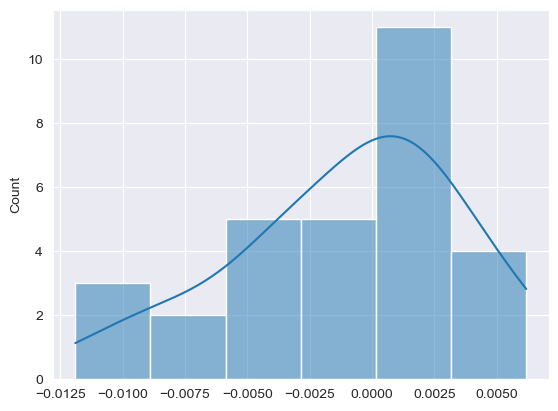

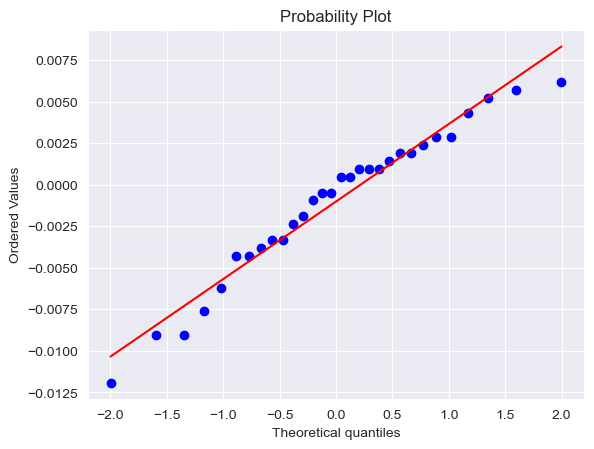

In [9]:
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

model1 = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('vectorizer', TfidfVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None), 'REVIEW_TEXT'),
        ('vp', OneHotEncoder(), ['VERIFIED_PURCHASE']),
        ('embeddings', SentenceEmbeddingTransformer(), 'Sentence_Embeddings'),
    ], n_jobs=-1)),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1, bootstrap= False, criterion= 'log_loss', max_depth= None, n_estimators= 800)),
])
model2 = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('vectorizer', TfidfVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None), 'REVIEW_TEXT'),
        ('vp', OneHotEncoder(), ['VERIFIED_PURCHASE']),
    ], n_jobs=-1)),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1, bootstrap= False, criterion= 'log_loss', max_depth= 60, n_estimators= 800)),
])

rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# Store the differences between model performances
differences = []

for train_index, test_index in rkf.split(df, df['LABEL']):
    # Split the data
    X_train, X_test = df.iloc[train_index], df.iloc[test_index]
    y_train, y_test = df['LABEL'].iloc[train_index], df['LABEL'].iloc[test_index]

    model1.fit(X_train, y_train)
    model2.fit(X_train, y_train)
    
    y_pred1 = model1.predict(X_test)
    y_pred2 = model2.predict(X_test)
    
    acc1 = accuracy_score(y_test, y_pred1)
    acc2 = accuracy_score(y_test, y_pred2)
    
    differences.append(acc1 - acc2)

differences = np.array(differences)

# Histogram
sns.histplot(differences, kde=True)
plt.show()

# Q-Q plot
stats.probplot(differences, dist="norm", plot=plt)
plt.show()

Perform Wilcoxon signed-rank test

In [12]:
from scipy.stats import wilcoxon

w_p_value = wilcoxon(differences)
print('Wilcoxon signed-rank test p-value:', w_p_value)

Wilcoxon signed-rank test p-value: WilcoxonResult(statistic=194.5, pvalue=0.4399667661637068)
